In [43]:
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, GroupShuffleSplit
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']

# path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [3]:
df_markers = pd.DataFrame()

for i,v in enumerate(all_participants): 
    participant = v
    
    folder = path + participant +'/'
    
    df_ = pd.read_csv(folder+ participant + '_' + epoch_type + '_all_marker.csv', index_col = 0)
    df_['participant'] = i
    df_markers = df_markers.append(df_)
    
df_markers.to_csv('all_markers.csv')

# Mulivariate analysis: On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [84]:
df_mind = (
    df_markers
    .query("probe == 'PC'")
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
#     .query("mind != 'dMW'") #if you want to test against just one of the mw
    .drop(['participant', 'probe', 'mind'], axis = 1) # drop mind or mind2 also
)

{'SVM__C': 10, 'SVM__gamma': 0.01}
AUC whole_model = 0.6285878300803673
Index(['mw', 'on-task'], dtype='object')


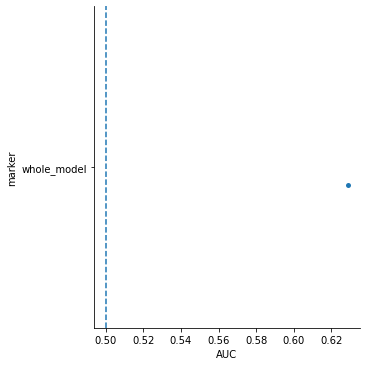

In [5]:
AUC = []
y, label = pd.factorize(df_mind['mind2'])
X = df_mind.drop('mind2', axis=1).astype('float32').values
steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
pipe = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y)
parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01, 0.001]}
grid = GridSearchCV(pipe, param_grid=parameteres, cv=5)
grid.fit(X_train, y_train)
y_proba = grid.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba[:,1])
print(grid.best_params_)
print(f'AUC whole_model = {auc}')
AUC.append(['whole_model', auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

Index(['mw', 'on-task'], dtype='object')


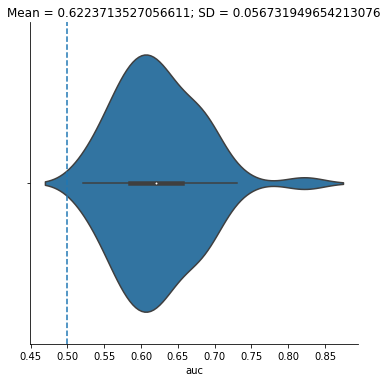

In [79]:
y, label = pd.factorize(df_mind['mind2'])
X = df_mind.drop('mind2', axis=1).astype('float32').values
steps = [('scaler', StandardScaler()), ('SVM', SVC(C = 0.001, gamma = 0.1, kernel = 'rbf',probability=True))]
pipe = Pipeline(steps)
cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                       random_state=42)

aucs = cross_val_score(
    X=X, y=y, estimator=pipe,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))


print(label)
auc = pd.DataFrame(aucs, columns = ['auc'])
sns.catplot(x = 'auc', orient = 'h', data = auc, kind = 'violin')
plt.title(f'Mean = {np.mean(aucs)}; SD = {np.std(aucs)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()



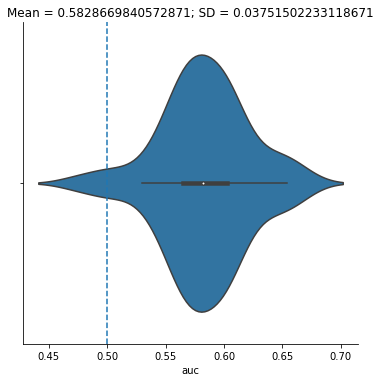

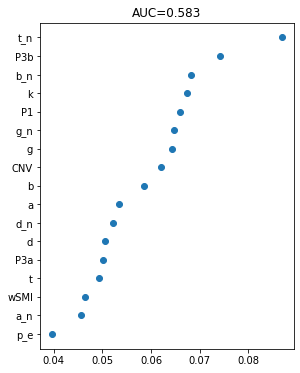

In [101]:
y, label = pd.factorize(df_mind['mind2'])
X = df_mind.drop('mind2', axis=1).astype('float32').values
n_estimators = 2000
doc_forest = make_pipeline(
    RobustScaler(),
    ExtraTreesClassifier(
        n_estimators=n_estimators, max_features=1, criterion='entropy',
        max_depth=4, random_state=42, class_weight='balanced'))

cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                       random_state=42)

aucs = cross_val_score(
    X=X, y=y, estimator=doc_forest,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

auc = pd.DataFrame(aucs, columns = ['auc'])
sns.catplot(x = 'auc', orient = 'h', data = auc, kind = 'violin')
plt.title(f'Mean = {np.mean(aucs)}; SD = {np.std(aucs)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

markers = df_mind.drop('mind2', axis = 1).columns

doc_forest.fit(X, y)
variable_importance = doc_forest.steps[-1][-1].feature_importances_
sorter = variable_importance.argsort()

# shorten the names a bit.
var_names = list(markers)
var_names = [var_names[ii]for ii in sorter]

# let's plot it
plt.figure(figsize=(8, 6))
plt.scatter(
    doc_forest.steps[-1][-1].feature_importances_[sorter],
    np.arange(17))
plt.yticks(np.arange(17), var_names)
plt.subplots_adjust(left=.46)
plt.title('AUC={:0.3f}'.format(np.mean(aucs)))
plt.show()

# Univariate analysis: dMW Vs sMW
This will be only performed in SC as they have more trials

In [107]:
df_mw = (
    df_markers
    .query("probe == 'PC'")
    .query("mind != 'on-task'")
    .drop(['participant', 'probe'], axis = 1)
)

AUC whole_model = 0.6942959001782532
Index(['dMW', 'sMW'], dtype='object')


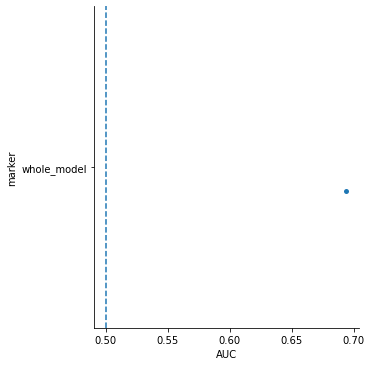

In [108]:
AUC = []
y, label = pd.factorize(df_mw['mind'])
X = df_mw.drop('mind', axis=1).astype('float32').values
steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
pipe = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y)
parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01, 0.001]}
grid = GridSearchCV(pipe, param_grid=parameteres, cv=5)
grid.fit(X_train, y_train)
y_proba = grid.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba[:,1])
print(f'AUC whole_model = {auc}')
AUC.append(['whole_model', auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

Index(['dMW', 'sMW'], dtype='object')


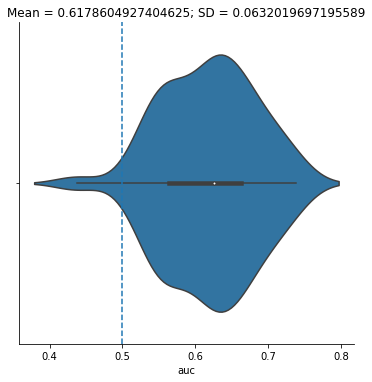

In [109]:
y, label = pd.factorize(df_mw['mind'])
X = df_mw.drop('mind', axis=1).astype('float32').values
steps = [('scaler', StandardScaler()), ('SVM', SVC(C = 0.001, gamma = 0.1, kernel = 'rbf', probability=True))]
pipe = Pipeline(steps)
cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                       random_state=42)

aucs = cross_val_score(
    X=X, y=y, estimator=pipe,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))


print(label)
auc = pd.DataFrame(aucs, columns = ['auc'])
sns.catplot(x = 'auc', orient = 'h', data = auc, kind = 'violin')
plt.title(f'Mean = {np.mean(aucs)}; SD = {np.std(aucs)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()



In [110]:
y, label = pd.factorize(df_mw['mind'])
X = df_mw.drop('mind', axis=1).astype('float32').values
n_estimators = 2000
doc_forest = make_pipeline(
    RobustScaler(),
    ExtraTreesClassifier(
        n_estimators=n_estimators, max_features=1, criterion='entropy',
        max_depth=4, random_state=42, class_weight='balanced'))

cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                       random_state=42)

aucs = cross_val_score(
    X=X, y=y, estimator=doc_forest,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

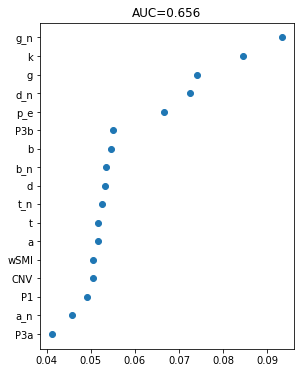

In [111]:
markers = df_mind.drop('mind2', axis = 1).columns

doc_forest.fit(X, y)
variable_importance = doc_forest.steps[-1][-1].feature_importances_
sorter = variable_importance.argsort()

# shorten the names a bit.
var_names = list(markers)
var_names = [var_names[ii]for ii in sorter]

# let's plot it
plt.figure(figsize=(8, 6))
plt.scatter(
    doc_forest.steps[-1][-1].feature_importances_[sorter],
    np.arange(17))
plt.yticks(np.arange(17), var_names)
plt.subplots_adjust(left=.46)
plt.title('AUC={:0.3f}'.format(np.mean(aucs)))
plt.show()

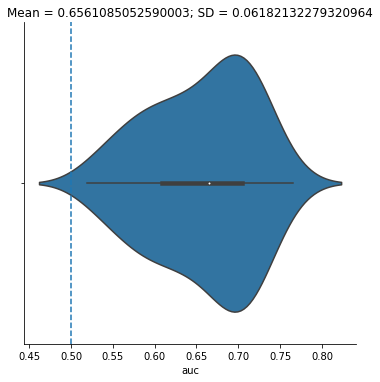

In [112]:
auc = pd.DataFrame(aucs, columns = ['auc'])
sns.catplot(x = 'auc', orient = 'h', data = auc, kind = 'violin')
plt.title(f'Mean = {np.mean(aucs)}; SD = {np.std(aucs)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()